# Prediction of subscription status based on customer demographic
## To increase recurring revenue by getting more subscribers 

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

## Load Data

In [2]:
data = pd.read_csv('shopping_behavior_updated.csv')
data

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,3896,40,Female,Hoodie,Clothing,28,Virginia,L,Turquoise,Summer,4.2,No,2-Day Shipping,No,No,32,Venmo,Weekly
3896,3897,52,Female,Backpack,Accessories,49,Iowa,L,White,Spring,4.5,No,Store Pickup,No,No,41,Bank Transfer,Bi-Weekly
3897,3898,46,Female,Belt,Accessories,33,New Jersey,L,Green,Spring,2.9,No,Standard,No,No,24,Venmo,Quarterly
3898,3899,44,Female,Shoes,Footwear,77,Minnesota,S,Brown,Summer,3.8,No,Express,No,No,24,Venmo,Weekly


In [3]:
data.describe()

,Customer ID,Age,Purchase Amount (USD),Review Rating,Previous Purchases
count,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000
mean,1950.500000,44.068462,59.764359,3.749949,25.351538
std,1125.977353,15.207589,23.685392,0.716223,14.447125
min,1.000000,18.000000,20.000000,2.500000,1.000000
25%,975.750000,31.000000,39.000000,3.100000,13.000000
50%,1950.500000,44.000000,60.000000,3.700000,25.000000
75%,2925.250000,57.000000,81.000000,4.400000,38.000000
max,3900.000000,70.000000,100.000000,5.000000,50.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         3900 non-null   

# Data cleaning

#### We map the data to appropriate numerical/categorical variables first

In [5]:
data['Payment Method'] = data['Payment Method'].replace({
    'Venmo': 'digital',
    'PayPal': 'digital',
    'Bank Transfer': 'digital',
    'Credit Card': 'card',
    'Debit Card': 'card',
    'Cash': 'cash'
})

Reduce the number of payment methods

In [6]:
def simplify_frequency(frequency):
    if 'Fortnightly' in frequency or 'Bi-Weekly' in frequency:
        return 'Fortnightly'
    elif 'Every 3 Months' in frequency:
        return 'Quarterly'
    else:
        return frequency
# Apply the function to the dataframe
data['Frequency of Purchases'] = data['Frequency of Purchases'].apply(simplify_frequency)

# Function to map simplified categories to numerical values
def map_to_months(simplified_frequency):
    if simplified_frequency == 'Fortnightly':
        return 26
    elif simplified_frequency == 'Weekly':
        return 52
    elif simplified_frequency == 'Monthly':
        return 12
    elif simplified_frequency == 'Quarterly':
        return 4
    elif simplified_frequency == 'Annually':
        return 1
    else:
        return None  # Handle any other cases if necessary
data['Frequency of Purchases'] = data['Frequency of Purchases'].apply(map_to_months)

Adjust frequency to number of purchases in a year

## Encoding target and feature variables

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.base import TransformerMixin

# A custom transformer to convert data to dense format
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

In [8]:
# Separate features and target
X = data[['Age', 'Previous Purchases', 'Discount Applied', 'Review Rating', 
            'Frequency of Purchases', 'Payment Method', 'Size', 
            'Purchase Amount (USD)', 'Item Purchased']]
# Encoding target variable
y = data['Subscription Status'].map({'Yes': 1, 'No': 0})  

Seperate targe and feature variables

In [9]:
# Preprocessing steps
numeric_features = ['Age', 'Previous Purchases', 'Review Rating', 'Purchase Amount (USD)']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_features = ['Frequency of Purchases', 'Payment Method', 'Size', 'Item Purchased', 'Discount Applied']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('to_dense', DenseTransformer())  # Ensure dense format
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the modeling pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])


Use Onehotencoder to transform variables ready for Naive Bayes and random forest

## Initial Naive Bayes Model

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8430769230769231

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.8307692307692308



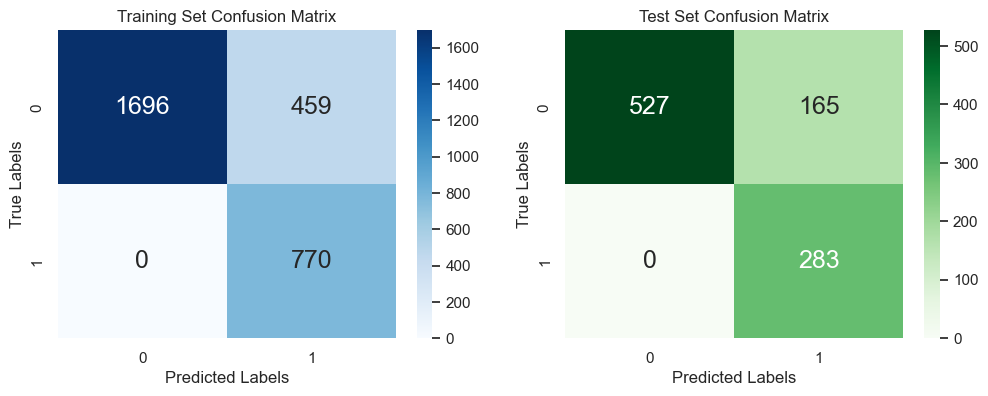

In [10]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predictions for evaluation
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Classification Accuracy
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", model.score(X_train, y_train))
print()

print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", model.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test sets
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt=".0f", 
           annot_kws={"size": 18}, ax=axes[0], cmap='Blues')
axes[0].set_title('Training Set Confusion Matrix')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

sb.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt=".0f", 
           annot_kws={"size": 18}, ax=axes[1], cmap='Greens')
axes[1].set_title('Test Set Confusion Matrix')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

plt.show()

#### Naive Bayes Model seems to be doing very well. Both train and test accuracy are similar with ~2% difference in performance

## Initial Random Forest Model

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 1.0

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.8235897435897436



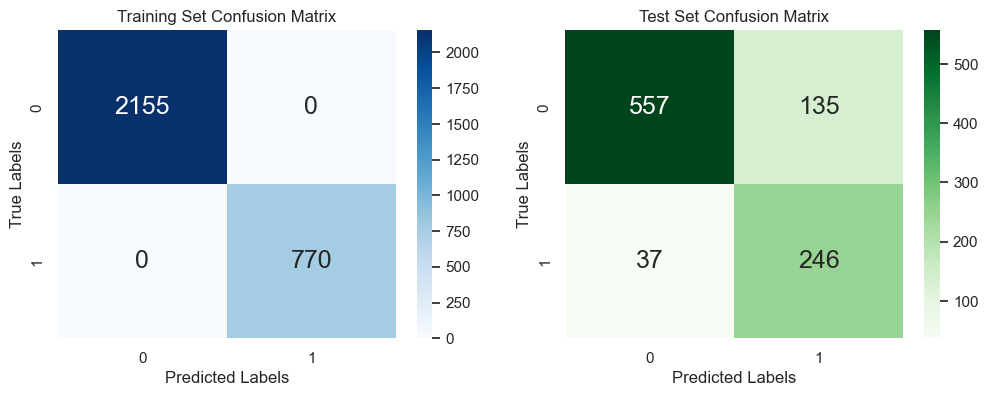

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Create the modeling pipeline with Random Forest
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_classifier)
])

# Fit the Random Forest model
rf_model.fit(X_train, y_train)

# Predictions for evaluation
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Classification Accuracy
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", rf_model.score(X_train, y_train))
print()

print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", rf_model.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test sets
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred_rf), annot=True, fmt=".0f", 
           annot_kws={"size": 18}, ax=axes[0], cmap='Blues')
axes[0].set_title('Training Set Confusion Matrix')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

sb.heatmap(confusion_matrix(y_test, y_test_pred_rf), annot=True, fmt=".0f", 
           annot_kws={"size": 18}, ax=axes[1], cmap='Greens')
axes[1].set_title('Test Set Confusion Matrix')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

plt.show()


#### Unlike our Naive Bayes model, our Random Forest Model has some issues. Train accuracy is 1 but test accuracy is only around 0.83. This shows that our Random Forest Model is overfitted. This may be due to the model capturing too much noise when training, failing to generalise the dataset patterns.

#### In order to fix the overfitting issue, we first find out which features are irrelevant by using the feature importance ranking of our Random Forest Model

## Feature Importance Plot

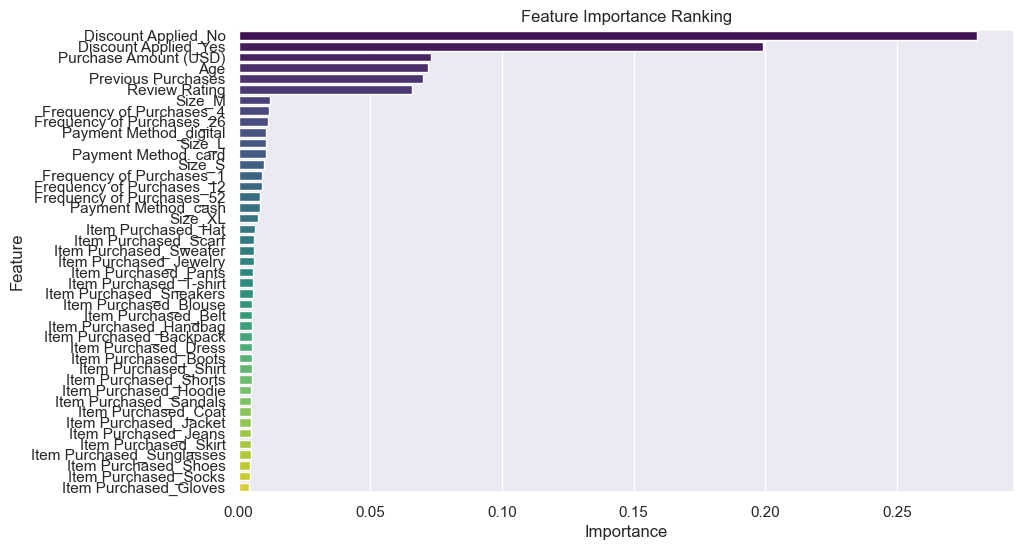

In [12]:
# Retrieve feature importances from the Random Forest model
feature_importances = rf_model.named_steps['classifier'].feature_importances_

# Get feature names for numeric features
numeric_feature_names = numeric_features

# Get feature names for categorical features after one-hot encoding
categorical_feature_names = rf_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)

# Combine feature names
feature_names = np.concatenate((numeric_feature_names, categorical_feature_names))

# Create a DataFrame to display feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance values in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sb.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance Ranking')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()



#### Base on the plot above, Discount Applied holds the highest importance for our Random Forest Model, which means we should definitely use it to train our Random Forest Model. Purchase amount, Age, Previous purchase and Review Rating are the next few highest features.

#### To balance out the dataset for training, we shall use 1 categorical feature (Discount Applied) and 1 numerical feature (Purchase Amount (USD)) to retrain both our Naive Bayes and Random Forest Models.